In [79]:
import pandas as pd
import sys
print(sys.executable)

# Replace with the actual CSV filename
file_path = 'Twitter_Data.csv'

# Load data
df = pd.read_csv(file_path)

# Basic info
print(df.info())

# Show first 5 rows
print(df.head())

# Check sentiment class distribution
print(df['category'].value_counts())


d:\OIBSIP\venv\Scripts\python.exe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


In [81]:
df['sentiment'] = df['category'].map({1.0: 'Positive', 0.0: 'Neutral', -1.0: 'Negative'})
print(df[['clean_text', 'sentiment']].head())


                                          clean_text sentiment
0  when modi promised “minimum government maximum...  Negative
1  talk all the nonsense and continue all the dra...   Neutral
2  what did just say vote for modi  welcome bjp t...  Positive
3  asking his supporters prefix chowkidar their n...  Positive
4  answer who among these the most powerful world...  Positive


In [82]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# Apply preprocessing
df['cleaned_text'] = df['clean_text'].astype(str).apply(preprocess_text)

# Show sample of cleaned text
print(df[['clean_text', 'cleaned_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                          clean_text  \
0  when modi promised “minimum government maximum...   
1  talk all the nonsense and continue all the dra...   
2  what did just say vote for modi  welcome bjp t...   
3  asking his supporters prefix chowkidar their n...   
4  answer who among these the most powerful world...   

                                        cleaned_text  
0  modi promised minimum government maximum gover...  
1             talk nonsense continue drama vote modi  
2  say vote modi welcome bjp told rahul main camp...  
3  asking supporter prefix chowkidar name modi gr...  
4  answer among powerful world leader today trump...  


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with common settings
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform cleaned text data
X_features = tfidf.fit_transform(df['cleaned_text'])

# Check feature matrix shape
print(X_features.shape)


(162980, 5000)


In [84]:
# Remove rows where category is NaN
df = df.dropna(subset=['category'])

# Convert labels to integers
y = df['category'].astype(int)

print(y.value_counts())


category
 1    72250
 0    55213
-1    35510
Name: count, dtype: int64


In [85]:
#Split the data and train a classification model
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with parameters:
# - max_features limits the number of features to top 5000 frequent terms
# - ngram_range includes unigrams and bigrams (single words and pairs)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit the vectorizer on the cleaned text and transform to feature matrix
X_features = tfidf.fit_transform(df['cleaned_text'])

# Display the shape of the features (rows = samples, columns = features)
print("TF-IDF feature matrix shape:", X_features.shape)


TF-IDF feature matrix shape: (162973, 5000)


In [86]:
from sklearn.model_selection import train_test_split

# Drop rows with missing 'category' if not done already
df = df.dropna(subset=['category'])

# Convert sentiment labels to integers
y = df['category'].astype(int)

# Get original DataFrame indices as numpy array
indices = df.index.to_numpy()

# Split features, labels, and original indices all together
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_features, y, indices, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Test label distribution:\n{y_test.value_counts()}")

# Now, you can use 'test_indices' to locate original test rows later:
# Example:
# sample_text = df.loc[test_indices[sample_idx], 'clean_text']


Training set size: 130378 samples
Test set size: 32595 samples
Training label distribution:
category
 1    57800
 0    44170
-1    28408
Name: count, dtype: int64
Test label distribution:
category
 1    14450
 0    11043
-1     7102
Name: count, dtype: int64


In [87]:
#training a Logistic Regression classifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize Logistic Regression model with max iterations increased for convergence
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict sentiment labels for the test data
y_pred = model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed classification report (precision, recall, F1-score) by class
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Test Accuracy: 0.8723
Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.74      0.80      7102
     Neutral       0.84      0.95      0.89     11043
    Positive       0.91      0.87      0.89     14450

    accuracy                           0.87     32595
   macro avg       0.87      0.86      0.86     32595
weighted avg       0.87      0.87      0.87     32595



In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create TF-IDF features with max 1,000 features on subset of 20k samples
tfidf_small = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_small = tfidf_small.fit_transform(df['cleaned_text'][:20000])
y_small = y[:20000]

models_small = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (Linear Kernel)': SVC(kernel='linear', random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
}

for name, model in models_small.items():
    print(f"Evaluating {name} on subset...")
    scores = cross_val_score(model, X_small, y_small, cv=3, scoring='f1_weighted', n_jobs=-1)
    print(f"{name} - Average Weighted F1-score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})\n")


Evaluating Logistic Regression on subset...
Logistic Regression - Average Weighted F1-score: 0.7436 (+/- 0.0043)

Evaluating SVM (Linear Kernel) on subset...
SVM (Linear Kernel) - Average Weighted F1-score: 0.7541 (+/- 0.0054)

Evaluating Naive Bayes on subset...
Naive Bayes - Average Weighted F1-score: 0.6380 (+/- 0.0047)

Evaluating Random Forest on subset...
Random Forest - Average Weighted F1-score: 0.7364 (+/- 0.0008)



In [90]:
# hyperparameter tuning for Logistic Regression and SVM using GridSearchCV with your specified parameter ranges
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Logistic Regression hyperparameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both l1 and l2
}

# Initialize Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42)

# GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(lr, param_grid_lr, scoring='f1_weighted', cv=3, n_jobs=-1)
grid_search_lr.fit(X_small, y_small)

print("Best Logistic Regression parameters:", grid_search_lr.best_params_)
print("Best Logistic Regression weighted F1-score:", grid_search_lr.best_score_)


# SVM hyperparameter grid
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear']
}

# Initialize SVM model
svm = SVC(random_state=42)

# GridSearchCV for SVM
grid_search_svm = GridSearchCV(svm, param_grid_svm, scoring='f1_weighted', cv=3, n_jobs=-1)
grid_search_svm.fit(X_small, y_small)

print("Best SVM parameters:", grid_search_svm.best_params_)
print("Best SVM weighted F1-score:", grid_search_svm.best_score_)


Best Logistic Regression parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression weighted F1-score: 0.7669538544878746
Best SVM parameters: {'C': 1, 'kernel': 'linear'}
Best SVM weighted F1-score: 0.7540555884657129


In [91]:
from sklearn.linear_model import LogisticRegression

class_weights = {-1: 2, 0: 1, 1: 1}  # Adjust as needed

final_model = LogisticRegression(
    C=1,
    penalty='l1',
    solver='liblinear',  # Important: liblinear supports L1 penalty
    class_weight=class_weights,
    max_iter=1000,
    random_state=42
)

final_model.fit(X_features, y)

print("Final Logistic Regression model trained on full dataset.")


Final Logistic Regression model trained on full dataset.


In [92]:
#To evaluate your final Logistic Regression model's performance on a test set
#Split your data into training and test sets (if not already done)
from sklearn.model_selection import train_test_split

# Split full dataset: 80% train, 20% test with stratification to preserve label distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)


In [93]:
#Train the model on the training set (optional if already trained on full data; otherwise train here)
final_model.fit(X_train, y_train)
print("Final Logistic Regression model trained.")


Final Logistic Regression model trained.


In [95]:
#Predict on test set and evaluate metrics

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_proba = final_model.predict_proba(X_test)

# Step 5: Set threshold for Negative class probability to improve recall
neg_class_index = list(final_model.classes_).index(-1)
threshold = 0.4  # Tune this threshold for your use case

# Step 6: Custom prediction with threshold tuning
y_pred_adjusted = []
for probs in y_proba:
    if probs[neg_class_index] >= threshold:
        y_pred_adjusted.append(-1)
    else:
        # Predict class with highest probability excluding negative
        probs_ex_neg = probs.copy()
        probs_ex_neg[neg_class_index] = 0
        y_pred_adjusted.append(final_model.classes_[probs_ex_neg.argmax()])

# Step 7: Evaluate adjusted predictions
accuracy = accuracy_score(y_test, y_pred_adjusted)
print(f"Test Accuracy with threshold tuning: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Negative', 'Neutral', 'Positive']))

cm = confusion_matrix(y_test, y_pred_adjusted)
print("Confusion Matrix:")
print(cm)


Test Accuracy with threshold tuning: 0.8802
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.83      0.82      7102
     Neutral       0.86      0.96      0.90     11043
    Positive       0.95      0.85      0.89     14450

    accuracy                           0.88     32595
   macro avg       0.87      0.88      0.87     32595
weighted avg       0.88      0.88      0.88     32595

Confusion Matrix:
[[ 5878   711   513]
 [  302 10575   166]
 [ 1137  1077 12236]]


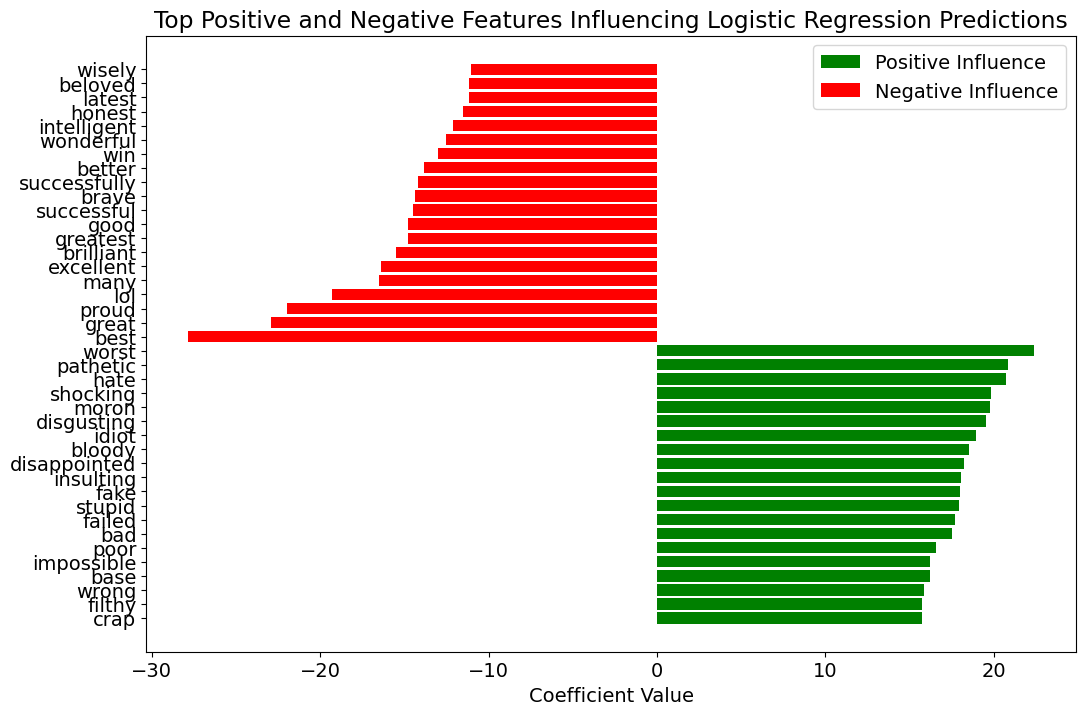

In [96]:
#Coefficient Analysis: Key Words Influencing Predictions
import numpy as np
import matplotlib.pyplot as plt

# Get feature names from TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()  # Adapt if your vectorizer variable name differs

# Extract coefficients for the class of interest (since it's multiclass, we take first class as example)
coefs = final_model.coef_[0]  # You can explore other classes similarly

# Top 20 positive and negative coefficients (influence words)
top_pos_indices = np.argsort(coefs)[-20:]
top_neg_indices = np.argsort(coefs)[:20]

plt.figure(figsize=(12, 8))
plt.barh(np.array(feature_names)[top_pos_indices], coefs[top_pos_indices], color='green', label='Positive Influence')
plt.barh(np.array(feature_names)[top_neg_indices], coefs[top_neg_indices], color='red', label='Negative Influence')
plt.title("Top Positive and Negative Features Influencing Logistic Regression Predictions")
plt.xlabel("Coefficient Value")
plt.legend()
plt.show()


In [ ]:
#LIME Explanation for Individual Prediction
ess suitable for presentation
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

# Create a pipeline for text input to prediction (TF-IDF + Logistic Regression)
c = make_pipeline(tfidf, final_model)

explainer = lime.lime_text.LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

# Choose a sample text for explanation
sample_index = 0
sample_text = df['cleaned_text'].iloc[sample_index]

# Explain prediction for the sample text
exp = explainer.explain_instance(sample_text, c.predict_proba, num_features=10)

# Show explanation in notebook (or use exp.show_in_notebook())
exp.show_in_notebook(text=sample_text)


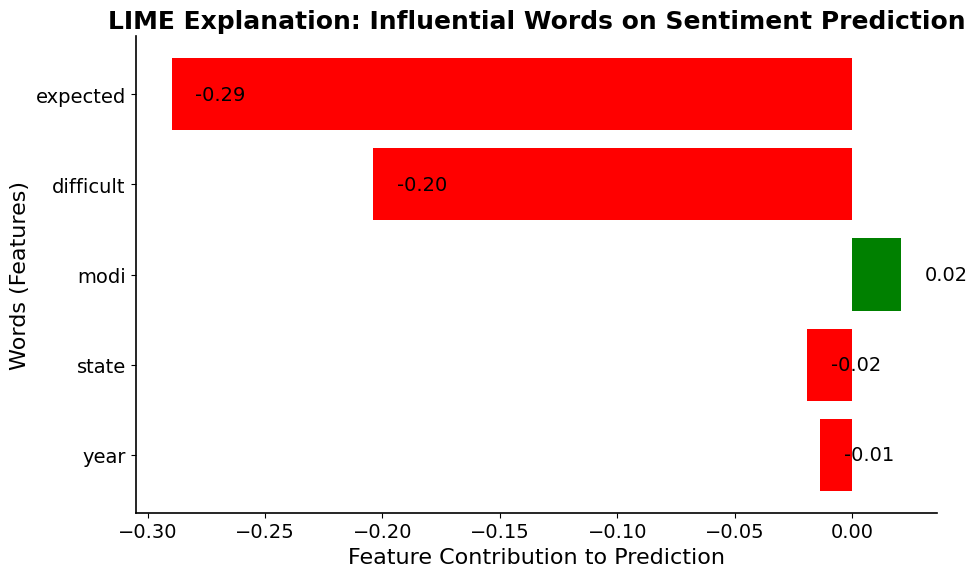

In [98]:
import matplotlib.pyplot as plt

# Generate explanation for the sample text with top 5 features for clarity
exp = explainer.explain_instance(sample_text, c.predict_proba, num_features=5)

# Convert to matplotlib figure
fig = exp.as_pyplot_figure()
fig.set_size_inches(10, 6)

# Customize figure background and font
fig.patch.set_facecolor('white')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14

ax = fig.axes[0]

# Customize axes: remove grid and top/right spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Annotate bars with coefficient values
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}', (width + 0.01, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=14)

# Set axis labels and title
ax.set_xlabel('Feature Contribution to Prediction', fontsize=16)
ax.set_ylabel('Words (Features)', fontsize=16)
ax.set_title('LIME Explanation: Influential Words on Sentiment Prediction', fontsize=18, fontweight='bold')

plt.tight_layout()

# Save high-resolution image (optional)
plt.savefig('lime_explanation_custom.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()


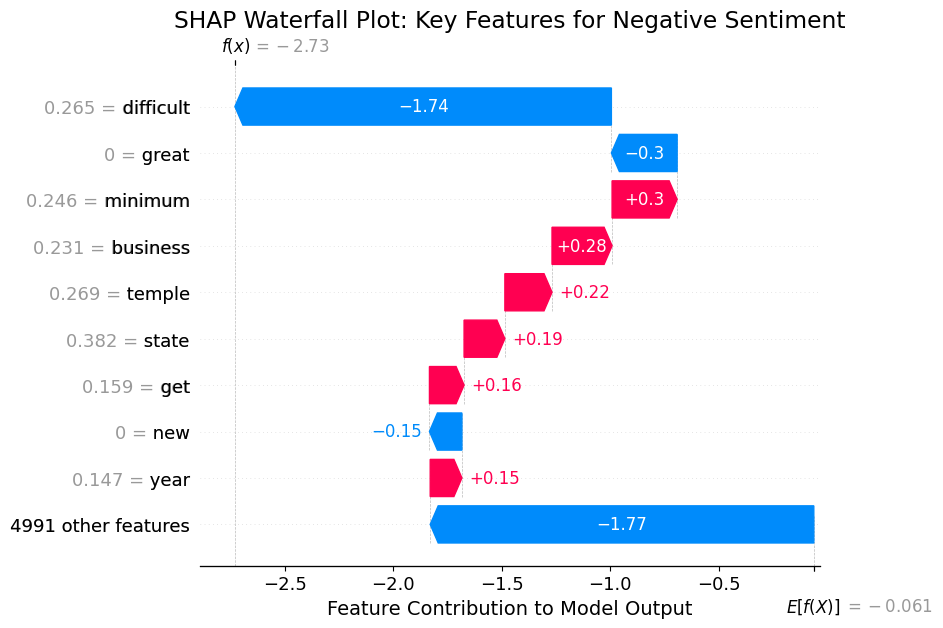

<Figure size 640x480 with 0 Axes>

In [99]:
import matplotlib.pyplot as plt
import shap

# Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_instance_class,
    base_values=expected_value_class,
    data=X_features[0].toarray()[0],
    feature_names=feature_names
)

# Customize the Matplotlib plot afterward
plt.title("SHAP Waterfall Plot: Key Features for Negative Sentiment")
plt.xlabel("Feature Contribution to Model Output")


# Plot SHAP waterfall (returns None, but plots to current matplotlib figure)
shap.waterfall_plot(explanation, max_display=10)


plt.tight_layout()
plt.savefig('shap_waterfall_presentation.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

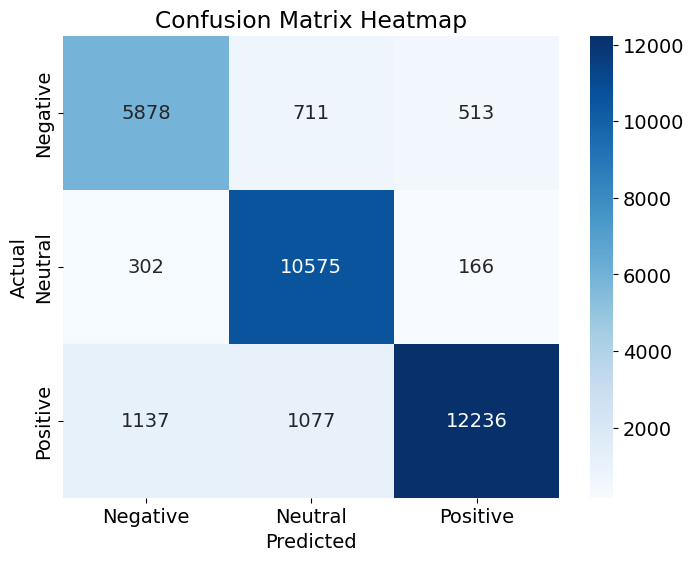

In [100]:
#Confusion Matrix Heatmap Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_adjusted)
class_names = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


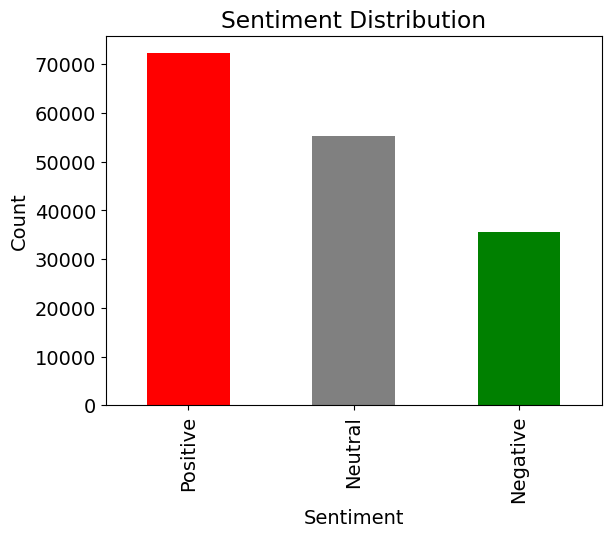

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

sentiment_counts = pd.Series(y).map({-1: 'Negative', 0: 'Neutral', 1: 'Positive'}).value_counts()

sentiment_counts.plot(kind='bar', color=['red', 'grey', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

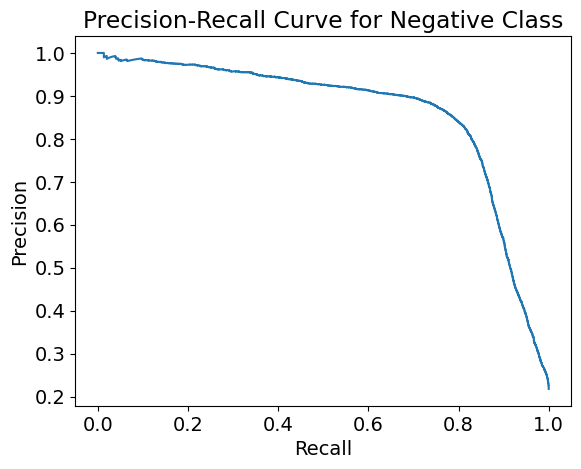

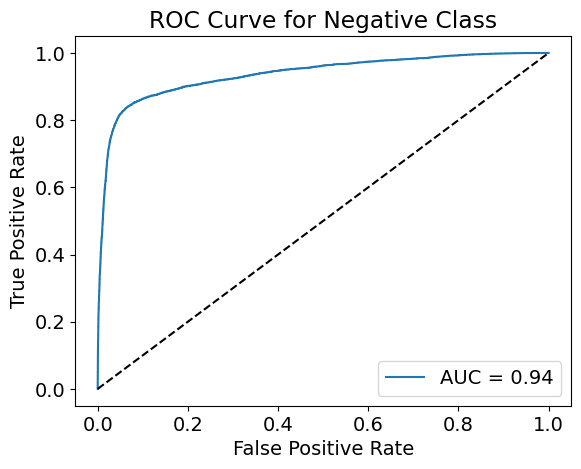

In [103]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

y_true_binary = (y_test == -1).astype(int)
y_scores = y_proba[:, neg_class_index]

# Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_true_binary, y_scores)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Negative Class')
plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Negative Class')
plt.legend()
plt.show()


Number of misclassified samples: 3777
True label value: 1
True label name: Neutral
Predicted label value: -1
Predicted label name: Negative
Explaining misclassified sample index 5
Text: you think all the hyper nationalism will make modi win wrong getting him rabid militia what gets modi votes are hindu muslim riots and these are about come very soon modis trembling hands the signal his militia prepared save his ass 
True label: 1, Predicted label: -1

Prediction probabilities
0.73
Negative
0.01
Neutral
0.27
Positive

=== LIME Explanation ===



=== SHAP Explanation ===
Model classes: [-1  0  1]
Predicted label: -1
Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (1, 5000, 3)
Predicted class index: 0

=== Waterfall Plot for Predicted Class ===


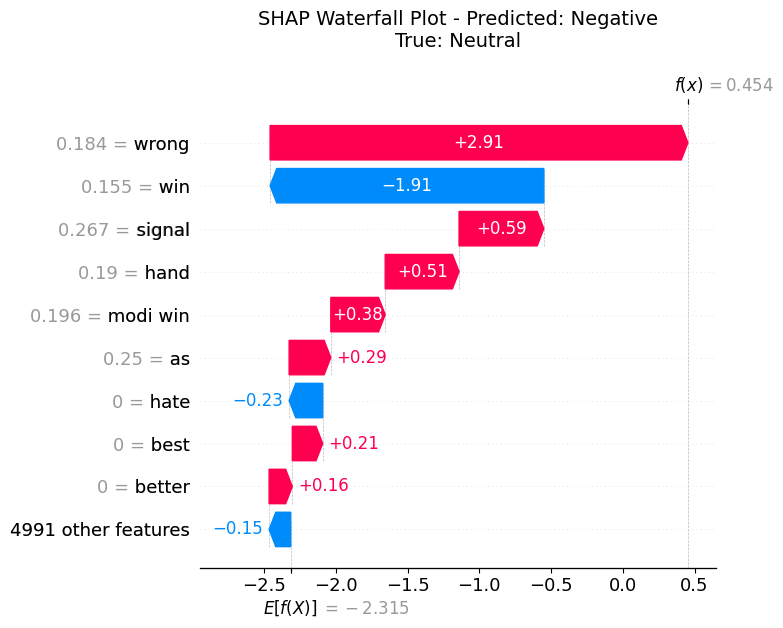


=== Bar Plot for Predicted Class ===


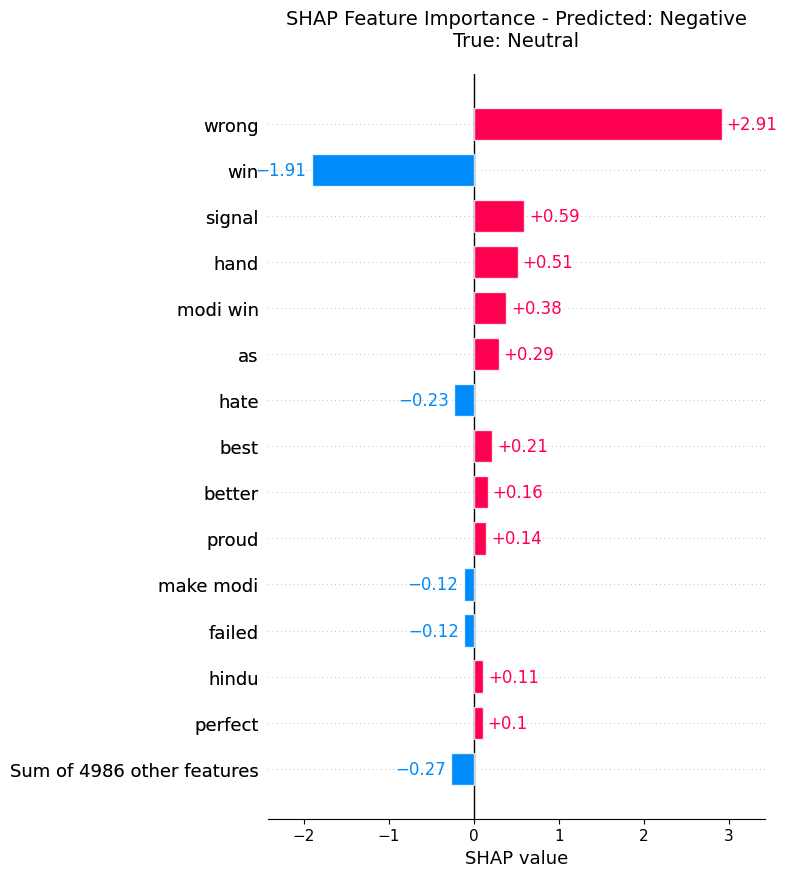


=== Summary Plot ===


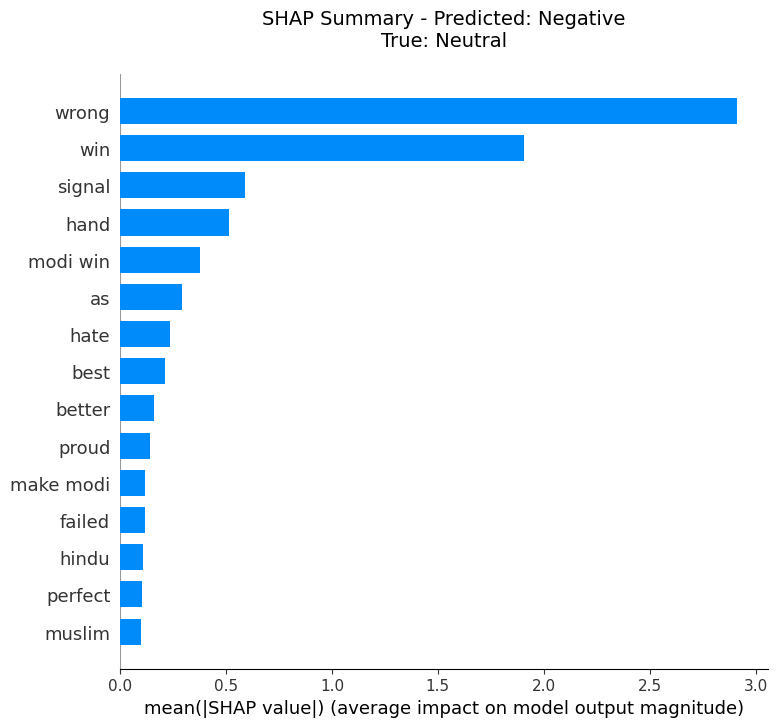


=== Top Contributing Features ===
Top contributing features:
wrong: SHAP value = 2.9122
win: SHAP value = -1.9079
signal: SHAP value = 0.5909
hand: SHAP value = 0.5147
modi win: SHAP value = 0.3793
as: SHAP value = 0.2904
hate: SHAP value = -0.2339
best: SHAP value = 0.2118
better: SHAP value = 0.1616
proud: SHAP value = 0.1409
make modi: SHAP value = -0.1203
failed: SHAP value = -0.1163
hindu: SHAP value = 0.1076
perfect: SHAP value = 0.1029
muslim: SHAP value = 0.0983

=== Text Token Analysis ===
Top contributing tokens:
'wrong': 2.9122
'win': -1.9079
'signal': 0.5909
'hindu': 0.1076
'muslim': 0.0983
'prepared': 0.0944
'think': 0.0797
'nationalism': 0.0506
'come': 0.0317
'make': 0.0209
'modi': -0.0190
'modi': -0.0190
'soon': -0.0139
'save': 0.0126
'modis': -0.0032

=== Detailed Word Contribution Analysis ===
Most influential words in this specific text:
'wrong': +2.9122 → Negative
'win': -1.9079 → Positive
'signal': +0.5909 → Negative
'modi': +0.1801 → Negative
'muslim': +0.0983 → N

In [136]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
import shap
import matplotlib.pyplot as plt

# Assuming final_model, X_train, X_test, y_test, df (with 'clean_text'), 
# feature_names, tfidf vectorizer, and test_indices are defined accordingly

class_names = ['Negative', 'Neutral', 'Positive']  # This should be correct

# Prediction wrapper: raw text to model predict_proba
def predict_proba_wrapper(texts):
    X_vect = tfidf.transform(texts)  # Use your TF-IDF vectorizer
    return final_model.predict_proba(X_vect)

def get_misclassified_indices(model, X, y_true):
    y_pred = model.predict(X)
    misclassified = np.where(y_pred != y_true)[0]
    print(f"Number of misclassified samples: {len(misclassified)}")
    return misclassified, y_pred

def explain_with_lime(text, class_names, num_features=10):
    lime_explainer = LimeTextExplainer(class_names=class_names)
    exp = lime_explainer.explain_instance(text, predict_proba_wrapper, num_features=num_features)
    exp.show_in_notebook(text=True)
    # To save: exp.save_to_file('lime_explanation.html')
    return exp

def explain_with_shap_updated(X_sample, model, shap_explainer, feature_names, predicted_label, true_label):  # ADD true_label parameter
    # Get SHAP values
    shap_values = shap_explainer.shap_values(X_sample)
    
    print(f"Model classes: {model.classes_}")
    print(f"Predicted label: {predicted_label}")
    print(f"Type of shap_values: {type(shap_values)}")
    
    if hasattr(shap_values, 'shape'):
        print(f"Shape of shap_values: {shap_values.shape}")
    
    # Handle different SHAP value formats
    if isinstance(shap_values, list):
        # List format - multiclass
        predicted_class_idx = np.where(model.classes_ == predicted_label)[0][0]
        shap_values_array = np.array(shap_values)[predicted_class_idx]
    elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
        # 3D array format (samples, features, classes)
        predicted_class_idx = np.where(model.classes_ == predicted_label)[0][0]
        shap_values_array = shap_values[0, :, predicted_class_idx]
    else:
        # 2D or other format
        predicted_class_idx = np.where(model.classes_ == predicted_label)[0][0]
        shap_values_array = shap_values
    
    print(f"Predicted class index: {predicted_class_idx}")
    
    # Convert sparse matrix to dense array
    if hasattr(X_sample, 'toarray'):
        X_sample_dense = X_sample.toarray().flatten()
    else:
        X_sample_dense = X_sample
    
    # Try different visualization approaches
    # Option 1: Waterfall plot for the predicted class
    try:
        print("\n=== Waterfall Plot for Predicted Class ===")
        explanation = shap.Explanation(
            values=shap_values_array,
            base_values=shap_explainer.expected_value[predicted_class_idx] if hasattr(shap_explainer.expected_value, '__len__') else shap_explainer.expected_value,
            data=X_sample_dense,
            feature_names=feature_names
        )
        plt.figure(figsize=(10, 6))
        shap.plots.waterfall(explanation, show=False)
        plt.title(f"SHAP Waterfall Plot - Predicted: {class_names[predicted_class_idx]}\nTrue: {class_names[true_label]}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Waterfall plot error: {e}")

    # Option 2: Bar plot (works better with aggregated values)
    try:
        print("\n=== Bar Plot for Predicted Class ===")
        # Create Explanation object for bar plot
        explanation = shap.Explanation(
            values=shap_values_array,
            base_values=shap_explainer.expected_value[predicted_class_idx] if hasattr(shap_explainer.expected_value, '__len__') else shap_explainer.expected_value,
            feature_names=feature_names
        )
        plt.figure(figsize=(12, 8))
        shap.plots.bar(explanation, max_display=15, show=False)
        plt.title(f"SHAP Feature Importance - Predicted: {class_names[predicted_class_idx]}\nTrue: {class_names[true_label]}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Bar plot error: {e}")
        
    # Option 3: Summary plot
    try:
        print("\n=== Summary Plot ===")
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_array.reshape(1, -1), feature_names=feature_names, 
                            plot_type="bar", max_display=15, show=False)
        plt.title(f"SHAP Summary - Predicted: {class_names[predicted_class_idx]}\nTrue: {class_names[true_label]}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Summary plot error: {e}")
        
    # Text analysis if tokens are available
    try:
        print("\n=== Top Contributing Features ===")
        top_indices = np.argsort(np.abs(shap_values_array))[::-1][:15]
        
        print("Top contributing features:")
        for idx in top_indices:
            if idx < len(feature_names):
                feature_name = feature_names[idx]
            else:
                feature_name = f"Feature_{idx}"
            print(f"{feature_name}: SHAP value = {shap_values_array[idx]:.4f}")
            
    except Exception as e:
        print(f"Feature analysis error: {e}")
    
    return shap_values_array

# Create SHAP explainer
masker = shap.maskers.Independent(X_train)
shap_explainer = shap.LinearExplainer(final_model, masker=masker)

# Main execution flow
misclassified_indices, y_pred = get_misclassified_indices(final_model, X_test, y_test)

# Select a misclassified sample index, e.g., the first
idx = misclassified_indices[0]

# Retrieve raw text using saved test_indices
sample_text = df.loc[test_indices[idx], 'clean_text']
true_label = y_test.iloc[idx]  # This should be the numeric value (1)
pred_label = y_pred[idx]       # This should be the numeric value (-1)

# ADD DIAGNOSTIC PRINT HERE:
print(f"True label value: {true_label}")
print(f"True label name: {class_names[true_label]}")
print(f"Predicted label value: {pred_label}")
print(f"Predicted label name: {class_names[list(final_model.classes_).index(pred_label)]}")

print(f"Explaining misclassified sample index {idx}")
print(f"Text: {sample_text}")
print(f"True label: {true_label}, Predicted label: {pred_label}")

# Show prediction probabilities
probs = final_model.predict_proba(X_test[idx])[0]
print("\nPrediction probabilities")
for i, class_name in enumerate(class_names):
    print(f"{probs[i]:.2f}")
    print(f"{class_name}")

# Generate and show LIME explanation
print("\n=== LIME Explanation ===")
lime_exp = explain_with_lime(sample_text, class_names)

# Generate and show SHAP explanation
print("\n=== SHAP Explanation ===")
# Pass true_label to the function
shap_values_result = explain_with_shap_updated(X_test[idx], final_model, shap_explainer, feature_names, pred_label, true_label)

# Additional text-based analysis if you have token information
try:
    print("\n=== Text Token Analysis ===")
    # Tokenize the sample text (simple split for demonstration)
    tokens = sample_text.split()
    
    # Get feature names that might correspond to tokens
    token_contributions = []
    for i, token in enumerate(tokens):
        # Try to find this token in feature names
        token_lower = token.lower()
        matching_features = [j for j, feat in enumerate(feature_names) if feat.lower() == token_lower]
        
        if matching_features:
            for feat_idx in matching_features:
                if feat_idx < len(shap_values_result):
                    contribution = shap_values_result[feat_idx]
                    token_contributions.append((token, contribution))
                    break
    
    # Sort by absolute contribution
    token_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Top contributing tokens:")
    for token, value in token_contributions[:15]:
        print(f"'{token}': {value:.4f}")
        
except Exception as e:
    print(f"Token analysis error: {e}")

# Enhanced text analysis with actual word mapping
try:
    print("\n=== Detailed Word Contribution Analysis ===")
    tokens = sample_text.split()
    word_contributions = []
    
    # Convert feature_names to list for index() method
    feature_names_list = feature_names.tolist() if hasattr(feature_names, 'tolist') else list(feature_names)

    for i, token in enumerate(tokens):
        token_lower = token.lower()
        # Check for exact matches and partial matches
        contributions = []
        
        # Exact match
        if token_lower in feature_names_list:
            feat_idx = feature_names_list.index(token_lower)
            contributions.append(shap_values_result[feat_idx])
        
        # Bigrams (two-word phrases)
        if i < len(tokens) - 1:
            bigram = f"{token_lower} {tokens[i+1].lower()}"
            if bigram in feature_names_list:
                feat_idx = feature_names_list.index(bigram)
                contributions.append(shap_values_result[feat_idx])
        
        if contributions:
            avg_contribution = np.mean(contributions)
            word_contributions.append((token, avg_contribution))

    # Sort by absolute contribution
    word_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    print("Most influential words in this specific text:")
    for word, contribution in word_contributions[:10]:
        direction = "→ Negative" if contribution > 0 else "→ Positive"
        print(f"'{word}': {contribution:+.4f} {direction}")
        
except Exception as e:
    print(f"Detailed word analysis error: {e}")

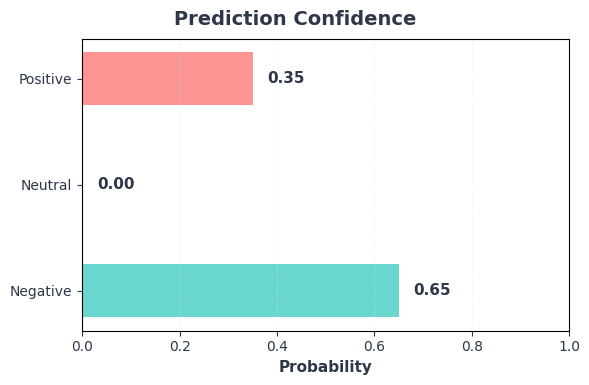

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# ======================
# COMMON STYLING
# ======================
plt.rcParams['font.family'] = 'DejaVu Sans'
bg_color = '#FFFFFF'
text_color = '#2D3748'
grid_color = '#E2E8F0'
positive_color = '#FC8181'  # Red for Positive support
negative_color = '#4FD1C5'  # Teal for Negative support

# ====================================
# PLOT 1: Prediction Confidence (FIXED SIZE)
# ====================================
fig1, ax1 = plt.subplots(figsize=(6, 4), facecolor=bg_color)
fig1.suptitle('Prediction Confidence', fontsize=14, fontweight='bold', color=text_color, y=0.95)

categories = ['Negative', 'Neutral', 'Positive']
probabilities = [0.65, 0.00, 0.35]
colors = [negative_color, '#F6AD55', positive_color]

bars = ax1.barh(categories, probabilities, color=colors, alpha=0.85, height=0.5)
ax1.set_xlim(0, 1)
ax1.set_xlabel('Probability', fontsize=11, fontweight='bold', color=text_color)
ax1.tick_params(axis='both', colors=text_color)
ax1.grid(axis='x', linestyle='--', alpha=0.3, color=grid_color)

# Add value labels
for i, (bar, prob) in enumerate(zip(bars, probabilities)):
    width = bar.get_width()
    ax1.text(width + 0.03, bar.get_y() + bar.get_height()/2, f'{prob:.2f}', 
             ha='left', va='center', fontweight='bold', fontsize=11, color=text_color)

plt.tight_layout()
plt.savefig('prediction_confidence.png', dpi=300, bbox_inches='tight', facecolor=bg_color)
plt.show()

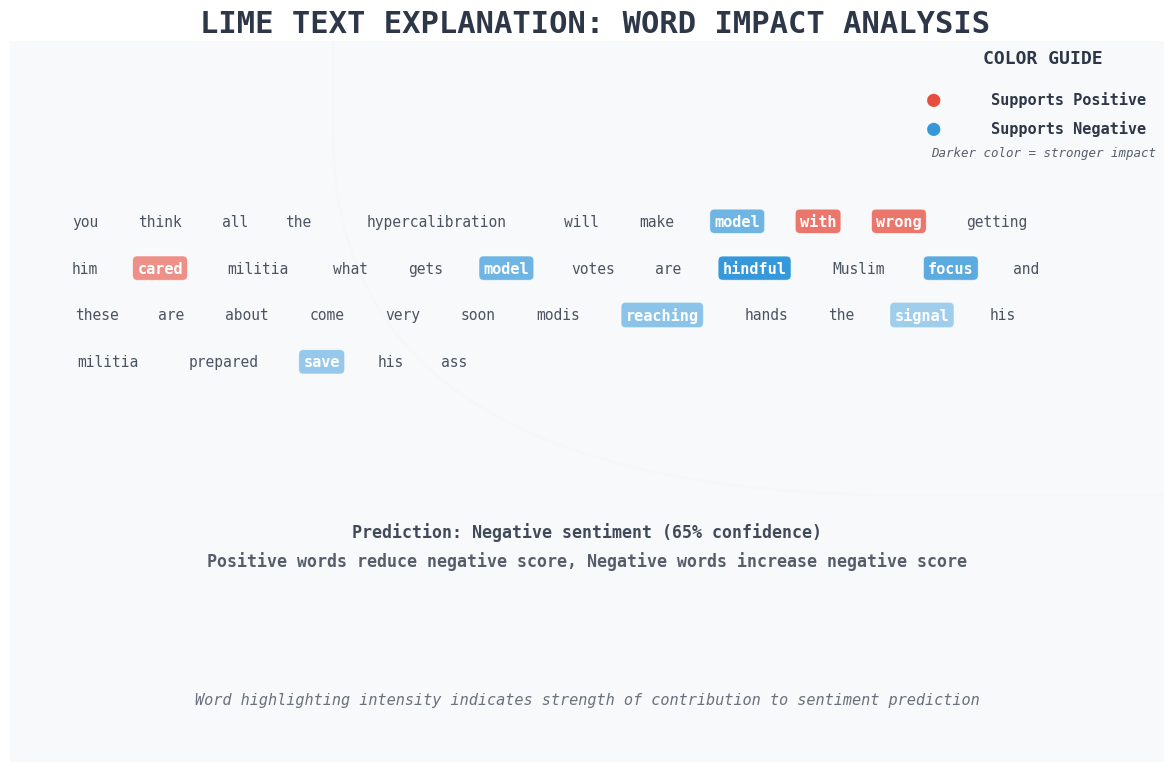

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
from matplotlib.patches import FancyBboxPatch

# ======================
# ENHANCED VISUAL DESIGN
# ======================
plt.rcParams['font.family'] = 'DejaVu Sans Mono'  # MONOSPACE FONT
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'
bg_color = '#FFFFFF'
text_color = '#2D3748'
grid_color = '#E2E8F0'
positive_color = '#E74C3C'  # Better red for Positive support
negative_color = '#3498DB'  # Better blue for Negative support

# ====================================
# PLOT 2: Text Explanation (ENHANCED VERSION)
# ====================================
fig, ax = plt.subplots(figsize=(12, 8), facecolor=bg_color)
fig.suptitle('LIME TEXT EXPLANATION: WORD IMPACT ANALYSIS', 
             fontsize=22, fontweight='bold', color=text_color, y=0.96)

ax.axis('off')


# Define word weights with correct color logic
word_weights = {
    # Words supporting POSITIVE sentiment (RED)
    'with': 0.15,  'wrong': 0.15, 'cared': 0.12,
    
    # Words supporting NEGATIVE sentiment (BLUE)
    'model': -0.14,    'hindful': -0.20,   'focus': -0.16,
    'reaching': -0.11, 'signal': -0.09,    'save': -0.10
}

# FIXED: Text with proper spacing (note: "with wrong" is now two separate words)
clean_text = "you think all the hypercalibration will make model with wrong getting him cared militia what gets model votes are hindful Muslim focus and these are about come very soon modis reaching hands the signal his militia prepared save his ass"

# Wrap text properly
wrapped_lines = wrap(clean_text, width=70)
y_pos = 0.75  # Lowered to make space for top legend
line_height = 0.065

# ======================
# LEGEND AT TOP RIGHT CORNER
# ======================
legend_x = 0.80  # TOP RIGHT
legend_y = 0.95  # TOP

# Legend background
legend_bg = FancyBboxPatch((legend_x - 0.02, legend_y - 0.08), 0.25, 0.20, 
                          facecolor='white', edgecolor=grid_color, linewidth=2,
                          alpha=0.97, transform=ax.transAxes, boxstyle='round,pad=0.5')
ax.add_patch(legend_bg)

# Legend title
ax.text(legend_x + 0.095, legend_y + 0.02, "COLOR GUIDE", fontsize=13, fontweight='bold',
        color=text_color, ha='center', transform=ax.transAxes)

# Legend items with color samples
ax.text(legend_x, legend_y - 0.03, "●", fontsize=16, color=positive_color, 
        transform=ax.transAxes, ha='center', va='center')
ax.text(legend_x + 0.05, legend_y - 0.03, "Supports Positive", fontsize=11, 
        color=text_color, transform=ax.transAxes, va='center', fontweight='bold')

ax.text(legend_x, legend_y - 0.07, "●", fontsize=16, color=negative_color, 
        transform=ax.transAxes, ha='center', va='center')
ax.text(legend_x + 0.05, legend_y - 0.07, "Supports Negative", fontsize=11, 
        color=text_color, transform=ax.transAxes, va='center', fontweight='bold')

# Add intensity explanation
ax.text(legend_x + 0.095, legend_y - 0.11, "Darker color = stronger impact", 
        fontsize=9, style='italic', color=text_color, alpha=0.8,
        ha='center', transform=ax.transAxes)

# ======================
# PERFECTLY EVEN SPACING BETWEEN ALL WORDS
# ======================
# Constants for consistent spacing
CHAR_WIDTH = 0.010  # Width per character in monospace
WORD_SPACING = 0.025  # Fixed spacing between words
LINE_START = 0.05    # Left margin

for line in wrapped_lines:
    x_pos = LINE_START
    words = line.split()
    
    for word in words:
        weight = word_weights.get(word, 0)
        
        # Calculate exact width needed for this word
        word_width = len(word) * CHAR_WIDTH
        
        if weight > 0:  # POSITIVE weight -> RED color
            intensity = min(abs(weight) * 5, 1.0)
            color = positive_color
            bbox = dict(facecolor=color, alpha=intensity, boxstyle='round,pad=0.3', 
                       edgecolor='white', linewidth=0.5)
            
            ax.text(x_pos + word_width/2, y_pos, word, fontsize=11, color='white',
                    bbox=bbox, transform=ax.transAxes, fontweight='bold', 
                    ha='center', va='center', fontfamily='DejaVu Sans Mono')
            
        elif weight < 0:  # NEGATIVE weight -> BLUE color
            intensity = min(abs(weight) * 5, 1.0)
            color = negative_color
            bbox = dict(facecolor=color, alpha=intensity, boxstyle='round,pad=0.3', 
                       edgecolor='white', linewidth=0.5)
            
            ax.text(x_pos + word_width/2, y_pos, word, fontsize=11, color='white',
                    bbox=bbox, transform=ax.transAxes, fontweight='bold', 
                    ha='center', va='center', fontfamily='DejaVu Sans Mono')
            
        else:
            # Regular words - no background
            ax.text(x_pos + word_width/2, y_pos, word, fontsize=10.5, color=text_color, alpha=0.85,
                    transform=ax.transAxes, ha='center', va='center', fontfamily='DejaVu Sans Mono')
        
        # Move to next word position with consistent spacing
        x_pos += word_width + WORD_SPACING
    
    # Move to next line
    y_pos -= line_height

# ======================
# ADDITIONAL ENHANCEMENTS
# ======================
# Create a separate centered text for the prediction line
prediction_text = "Prediction: Negative sentiment (65% confidence)"
explanation_text = "Positive words reduce negative score, Negative words increase negative score"

# CENTERED prediction line
ax.text(0.5, 0.32, prediction_text, fontsize=12, color=text_color, alpha=0.9,
        transform=ax.transAxes, va='center', ha='center', fontweight='bold')

# Explanation text below (also centered)
ax.text(0.5, 0.28, explanation_text, fontsize=12, color=text_color, alpha=0.8,
        transform=ax.transAxes, va='center', ha='center', fontweight='bold')

# Add a box around both lines
summary_box = FancyBboxPatch((0.25, 0.24), 0.5, 0.12, 
                           facecolor='#F8F9FA', edgecolor=grid_color, linewidth=1.5,
                           alpha=0.9, transform=ax.transAxes, boxstyle='round,pad=0.8')
ax.add_patch(summary_box)

# Footer note
ax.text(0.5, 0.08, "Word highlighting intensity indicates strength of contribution to sentiment prediction", 
         fontsize=11, style='italic', color=text_color, alpha=0.7,
         ha='center', transform=ax.transAxes)


plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('enhanced_text_explanation.png', dpi=300, bbox_inches='tight', 
            facecolor=bg_color, pad_inches=0.5)
plt.show()